# Implementing into pipeline

Now we take the code I've made to filter and generate traces and implement it into the framework of Alex's pipeline. 

First, the filter_and_downsample.py file used to read in AOSLO data, which takes the .mat files direclty, downsamples them to 1000 frames/second (1 ms), filters them (sliding window) and saves them as a .mat files in the format: (number of paths, number of timesteps, 2 = number dimensions of path).

Here is the original file:

In [1]:
if(0):
    # Python script to low pass filter and downsample high frequency AOSLO data
    #  takes all .mat files in <data_dir> filters them, and downsamples them
    #
    # Saves a file in output_dir with the paths in a .mat file in the format:
    #    (number of paths, number of timesteps, 2 = number dimensions of path)

    import numpy as np
    import os
    import sys
    from scipy.io import loadmat, savemat
    from scipy.interpolate import interp1d
    from pykalman import KalmanFilter



    # Parameters

    print 'Ensure that parameters are correct before running'

    pix_to_deg = 429.
    #pix_to_deg = 392. # See pix_to_deg.txt for correct value
    data_desc = '8_19_2014_aoslo_data'

    resample_dt = 0.001 # Get samples with this time between samples

    show_plots = True # Make true to show plots to help debug
    if show_plots:
        import matplotlib.pyplot as plt


    # Moving average parameters
    a = 7 # Number of timesteps to do moving average over

    # Kalman smoothing parameters
    sigma_p = 30. # Initial velocity standard deviation arcmin/s
    sigma_t = 0.04 # Hidden state transition noise
    sigma_o = 0.5 # Observation noise

    # File I/O Params
    data_dir = 'data_high_freq/'

    fn_s = [fn for fn in os.listdir(data_dir) if fn.endswith('.mat')]

    output_dir = 'resampled_data/'


    def moving_average(x, y, a = 7):
        """
        Moving average to smooth out 'jumps'
        a = 7 suggested by Roorda group
        """
        f = np.ones((a,))/ (1.0 * a)
        xf = np.convolve(f, x, mode = 'same')
        yf = np.convolve(f, y, mode = 'same')
        return xf, yf


    def process_data(filename):
        """
        Preprocesses data
        filename - .mat filename to high frequency aoslo data
        Applies the following transformations:
        -- Moving average filter to damp out large jumps
        -- Applies kalman smoother to damp out tumbling E artifacts
        Returns filtered path in matrix form:
        (N_T, 2)
        """
        data = loadmat(os.path.join(data_dir, filename))

        scale = 1. / pix_to_deg * 60. # Conversion from pixels to arcmins

        t = data['timeaxis_secs'][:, 0]
        t = t - t[0]
        dt = t[1] - t[0]
        f0 = dt ** -1 # Data frequency

        print 'Time interval = %0.2f s' % t[-1]

        xy = data['frameshifts_strips_spline'] * scale
        x = xy[:, 0]
        y = xy[:, 1]
        x = x - x[0]
        y = y - y[0]

        # Prefilter data (i.e. large jumps)
        xf, yf = moving_average(x, y, a = a)
        xf = xf - xf[0]
        yf = yf - yf[0]
        xyf = np.zeros_like(xy)
        xyf[:, 0] = xf
        xyf[:, 1] = yf

        # Kalman Smoothing

        e1 = np.array([[1, 0, 0, 0], 
                       [0, 0, 0, 0], 
                       [0, 0, 1, 0],
                       [0, 0, 0, 0]])

        e2 = np.array([[0, 0, 0, 0], 
                       [0, 1, 0, 0], 
                       [0, 0, 0, 0],
                       [0, 0, 0, 1]])

        kf = KalmanFilter(transition_matrices = [[1, dt, 0, 0], 
                                                 [0, 1, 0, 0], 
                                                 [0, 0, 1, dt],
                                                 [0, 0, 0, 1]],
                          transition_covariance = sigma_t * e2,
                          observation_matrices = [[1, 0, 0, 0], 
                                                  [0, 0, 1, 0]],
                          observation_covariance = sigma_o * np.eye(2),
                          initial_state_mean = np.zeros(4),
                          initial_state_covariance = sigma_p * e2
                          )


        (smoothed_state_means, smoothed_state_covariances) = kf.smooth(xyf)

        XYk = smoothed_state_means[:, (0,2)]
        Vk = smoothed_state_means[:, (1,3)]

        # Interpolation and downsampling
        fx = interp1d(t, XYk[:, 0])
        fy = interp1d(t, XYk[:, 1])

        # New times
        tp = np.arange(0, t[-1], resample_dt)

        xr = fx(tp)
        yr = fy(tp)

        xyr = np.zeros((tp.shape[0], 2))
        xyr[:, 0] = xr
        xyr[:, 1] = yr

        return xy, xyf, xyr

    def debug_plots(xy, xyf, xyr):
        """
        Create plots of the data during the preprocessing
        xy - Raw data
        xyf - Raw data with a moving average filter
        xyr - resampled Kalman smoothed data
        """
        plt.figure(figsize = (15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(xy[:, 0], xy[:, 1])
        plt.title('Raw Path')
        plt.xlabel('x (arcmin)')
        plt.ylabel('y (arcmin)')

        plt.subplot(1, 3, 2)
        plt.plot(xyf[:, 0], xyf[:, 1])
        plt.title('Moving Average Filtered Path')

        plt.subplot(1, 3, 3)
        plt.plot(xyr[:, 0], xyr[:, 1])
        plt.title('Kalman Smoothed Path')

        plt.show()


    fn_s = fn_s[0:2]

    for i, fn in enumerate(fn_s):
        xy, xyf, xyr = process_data(fn)
        try:
            resampled_paths
        except NameError:
            N_T_resample = xyr.shape[0]
            resampled_paths = np.zeros((len(fn_s), 
                                        N_T_resample, 2)).astype('float32')        

        resampled_paths[i, :, :] = xyr
        if show_plots:
            debug_plots(xyr, xyf, xy)


    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    out_fn = 'resampled_paths'

    d = {}
    d['paths'] = resampled_paths
    d['data_desc'] = data_desc
    d['DT'] = resample_dt

    savemat(os.path.join(output_dir, out_fn), d)


Second, the path_generator.py file used to create different types of traces (diffusion or velocity model) and save them as .mat files.  
See original at https://github.com/alexanderganderson/fixated_eye_model/blob/master/utils/path_generator.py

In [2]:
if(0):
    import numpy as np
    from scipy.io import loadmat
    import abc


    class Center:

        def __init__(self, Lx, DC, DT):
            """
            Class that Implements a diffusing center in a box of size Lx
            Lx = linear dimension of square to diffuse in
            DC = diffusion constant
            DT = timestep size
            x = coordinates of the current location of the random walk,
                initialized as [0, 0]
            Initializes Center Object
            """
            self.Lx = Lx
            self.DC = DC
            self.m0 = np.array([0, 0], dtype='float64')  # current position
            self.DT = DT
            # The diffusion is biased towards the center by taking a product of
            # gaussians
            # A product of gaussians is also a gaussian with mean, sdev given as
            # (mn, sn)
            self.m1 = np.array([0, 0], dtype='float64')  # center of image
            # Standard deviation for diffusion
            self.s0 = np.sqrt(self.DC * self.DT)
            self.s1 = self.Lx / 4  # Standard Deviation for centering gaussian
            self.sn = 1 / np.sqrt(1 / self.s0 ** 2 + 1 / self.s1 ** 2)

        def advance(self):
            """
            Updates location according to a random walk that stays within a box
            """

            self.mn = (
                self.m0 / self.s0 ** 2 + self.m1 / self.s1 ** 2) * self.sn ** 2
            while(True):
                # Note that for 2d diffusion, each component's variance is half the
                #   variance of the overall step length
                temp = self.mn + \
                    np.random.normal(size=2, scale=self.sn / np.sqrt(2))
                if (temp[0] > - self.Lx / 2
                        and temp[0] < self.Lx / 2
                        and temp[1] > - self.Lx / 2
                        and temp[1] < self.Lx / 2):
                    self.m0 = temp
                    break

        def get_center(self):
            return self.m0

        def reset(self):
            self.m0 = np.array([0, 0], dtype='float64')

        def __str__(self):
            return str(self.x)


    class PathGenerator():
        __metaclass__ = abc.ABCMeta

        @abc.abstractmethod
        def __init__(self, N_T, *args):
            """
            Initialize a 2d Path Generator
            """
            self.N_T = N_T

        @abc.abstractmethod
        def gen_path(self):
            """
            Generates a 2d path with N_T timesteps starting at (0,0)
            """
            return np.zeros((2, self.N_T))

        @abc.abstractmethod
        def mode(self):
            """
            Returns a string describing the path
            """
            return ' '


    class DiffusionPathGenerator(PathGenerator):

        def __init__(self, N_T, Lx, DC, DT):
            """
            Creates a path generator that does bounded diffusion
            N_T - number of timesteps to generate path
            Lx - window that the diffusion is restricted to
            DC - diffusion constant
            DT - timestep
            """
            PathGenerator.__init__(self, N_T)
            self.c = Center(Lx, DC, DT)

        def gen_path(self):
            self.c.reset()
            path = np.zeros((2, self.N_T))
            for i in range(self.N_T):
                path[:, i] = self.c.get_center()
                self.c.advance()
            return path

        def mode(self):
            return 'Diffusion'


    class ExperimentalPathGenerator(PathGenerator):

        def __init__(self, N_T, filename, DT):
            """
            Creates a path generator that uses real experimental data
            filename - filename for pkl file that contains an array of paths
                  data['paths'] = (N_runs, number of timesteps, 2)
                  2 - number of dimensions of path eg. x,y
            """
            PathGenerator.__init__(self, N_T)
            self.data = loadmat(filename)
            self.DT = self.data['DT'][0, 0]
            self.paths = self.data['paths']
            self.N_runs, self.N_T_data, _ = self.paths.shape

            if not self.DT == DT:
                raise ValueError('Data timestep doesnt match simulation timestep')
            if self.N_T > self.N_T_data:
                pass  # raise ValueError('Simulation has more timesteps than data')

        def gen_path(self):
            """
            Generate a path from the data
            """
            q = np.random.randint(self.N_runs)
            st = np.random.randint(self.N_T_data - self.N_T)
            pat = self.paths[q, st:(st + self.N_T), :].transpose()
            pat[0] = pat[0] - pat[0][0]
            pat[1] = pat[1] - pat[1][0]
            return pat

        def mode(self):
            return 'Experimental_data'


    if __name__ == '__main__':
        fn = 'data/resampled_paths.mat'
        pg = ExperimentalPathGenerator(100, fn, 0.001)
        path = pg.gen_path()
        print path

## Implementing my own!

Now I'll implement my own version of the code.

define the class - eyetrace_class.py

In [3]:
##make a class type containing the info for an eye trace
class EyeTrace:
    """A class to contain eye trace information
    
    Creates an eyetrace instance lasting one second.
    For each timepoint/frame, there is both an x and y position, velocity, and accelerations.

    Args:
        xlocs (array[numeric]): list of measured x locations from time 0 to 1sec.
                                Must be either:
                                    1. given in pixels with an appropriate pixelscale
                                    or
                                    2. given in arcseconds with pixelscale = 1.
        ylocs (array[numeric]): list of measured y locations from time 0 to 1sec.
                                Must bethe same length as xlocs and either:
                                    1. given in pixels with an appropriate pixelscale
                                    or
                                    2. given in arcseconds with pixelscale = 1.
        time (array[numeric]): list of times in seconds of each measurement.
                                May not start at 0 but exptected to contain 1 sec of timepoints,
                                (must be same length as xlocs & ylocs)
        pixelscale (numeric): The number of pixels per degree for the trial
                              (should be 1 if xlocs and ylocs are given in arcseconds.)
        fname (charstring): A string to keep track of file information.
                            Can be set to the filename for keeping track of trial and subject information
                            Can also be used to denote this is a generated trial.            
    """
    def __init__(self, xlocs, ylocs, time, pixelscale, fname):
        ##define filename
        self.fname = fname
        
        ##define scaled time that starts at zero.
        self.time = time - time[0]
        self.pixelscale = pixelscale
        
        ##define x and y attributes
        ##position
        self.x = (xlocs - xlocs[0]) * pixelscale ## center at start and change from pixels to arcmins
        self.y = (ylocs - ylocs[0]) * pixelscale ## center at start and change from pixels to arcmins
        ##velocity in arcmins/frame
        ##note: we have to concatinate on the first position/velocity/acceleration 
        ##to keep the vector lengths consistent between all derivatives.
        ##this is especially imporant in plotting because we often plot 
        ##against time, which is the same length as x and y.
        self.xv = np.concatenate([[(self.x[1] - self.x[0])], 
                                   (self.x[1:] - self.x[:-1])]
                                   ) * len(self.time) ##in seconds
        
        self.yv = np.concatenate([[(self.y[1] - self.y[0])],
                                   (self.y[1:] - self.y[:-1])]
                                   ) * len(self.time) ##in seconds
        ##acceleration in arcmins/frame
        self.xa = np.concatenate([[(self.xv[1] - self.xv[0])], 
                                   (self.xv[1:] - self.xv[:-1])]
                                   ) * len(self.time) ##in seconds
        
        self.ya = np.concatenate([[(self.yv[1] - self.yv[0])],
                                   (self.yv[1:] - self.yv[:-1])]
                                   ) * len(self.time) ##in seconds


        ##define attributes to hold original data after filtering
        self.xraw = self.x
        self.yraw = self.y
        self.xvraw = self.xv
        self.yvraw = self.yv
        self.xaraw = self.xa
        self.yaraw = self.ya
        self.timeraw = self.time

        ##info on the filter - will edit these values when filter is implemented.
        self.filterinfo = 'none'
        self.kfivx = 0
        self.kfivy = 0
        self.kfiax = 0
        self.kfiay = 0
        self.kftvx = 0
        self.kftvy = 0
        self.kfov = 0
        self.kfdt = 0 
        

find and load files - find_and_load.py

In [4]:
##find all files
def find_and_load(dataDir = 'data'):
    """
    Loads in all *.mat files recursively in the given directory as eyetraces
    Args:
        dataDir (Optional[charstring]): name of directory (relative to working directory)
    Returns:
        List[Eyetrace]: A list of eyetraces, each corresponding to 1 .mat file in the directory.
    """
    from glob import glob
    #import eyetrace.py
    
    files = [y for x in os.walk(dataDir) for y in glob(os.path.join(x[0], '*.mat'))]
    #len(files)

    ##load them in
    trials = []
    for fh in files:

        ##if it's 20053 it's the stabilize case so skip it.
        if(re.search('20053', fh)):
            0
        elif(re.search('20094', fh)):
            0
        else:
            nfile = loadmat(fh)
            xss = nfile['frameshifts_strips_spline'][:, 0] 
            yss = nfile['frameshifts_strips_spline'][:, 1] 
            tss = nfile['timeaxis_secs'][:,0] ##extract time axis (1920 frames)

            ##add scale info
            #if(re.search('20053', fh)):
            #    scale = 392.
            if(re.search('20073', fh)):
                scale = 420.
            elif(re.search('20014', fh)):
                scale = 489.
            #elif(re.search('20094', fh)):
            #    scale = 379.
            else:
                raise ValueError('No scale available for file',nfile)
            scalar = 1. / scale * 60. # Conversion from pixels to arcmins
            trial = EyeTrace(xss, yss, tss, scalar, fh)
            trials.append(trial)
    #len(files)
    return trials

check correct number of frames - check_len.py

In [5]:
def check_len(trials, length):
    """
        Checks to make sure all trials are of the same expected length (number of frames), and removes those not conforming.

        This is an important check because some trials do not last an entire second.
        Therefore, need to check that the length of the trials is as expected for a given expierment.
        Args:
            trials (List[Eyetrace]): A list of eyetraces.
            length (Numeric): the expected length for the trials.
        Returns:
            List[Eyetrace]: A list of eyetraces of all length specified by 'length'
    """
    i=0
    while i < len(trials):
        if(len(trials[i].x) < length):
            del trials[i]
            ##if we've deleted the trial at n, our indexing is now 1 off and we need to go to the new n that took n's place.
            i = i-1
        i+=1

    #print len(trials)
    return trials

interpolate mirror failures - interp_mf.py

In [6]:
#interpolate mirror failures
def interp_mf(trial):
    """
        Identify instances of single mirror failures, and interpolate the positions at that point.
        
        Invariant of method used to determine outlier status.
        Args:
            trials (Eyetrace): An instance of eyetrace that may contain mirror failures.
        Returns:
            (Eyetrace): The given eyetrace with mirror failures inperpolated.
    """
    ##
    ##adapted from http://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
    def find_outliers_mad(signal, thresh):
        """
            Identify the outliers using the mean absolute deviation.
            Adapted from http://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data

            Args:
                signal (Array[Numeric]): A window of time of positions.
                
                thresh (Numeric): The number of standard deviations from the mean to reach outlier status.
            Returns:
                List[Numeric]: A list of the positions in the trial where an outlier was found.
        """
        if len(signal.shape) == 1:
            signal = signal[:,None]
        median = np.median(signal, axis=0)
        diff = np.sum((signal - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)
        modified_z_score = 0.6745 * diff / ( med_abs_deviation + 1e-10)
        return np.where(modified_z_score > thresh)

    ##madthresh
    madthresh = 5


    ##the displacement is t+1 - t
    xt1 = trial.x[:-1]
    xt2 = trial.x[1:]
    xd = xt2-xt1 ##THIS IS OK for Numpy Arrays
    yt1 = trial.y[:-1]
    yt2 = trial.y[1:]
    yd = yt2-yt1
    eud = np.append([0],(xd**2 + yd**2)**.5) #add zero so we have zero displacement for t=0
    #eud = (xd**2 + yd**2)**.5 #interstingly, this seems to work too. Probably because after mirror failure there is a large displacement back to normal signal.
    ##get the list of outliers
    outliers = find_outliers_mad(eud, madthresh)[0]
    #outliers = list(set(outliers))
    outliers= np.array(outliers)

    ##check that t-1 is not also an outlier (aka this is not the case of the first timepoint after return from mirror failure, also a large displacement.)
    ##also check that t+1 is not out of bounds
    foutliers = np.array(outliers)
    #print "outliers before filtering:"
    #print outliers
    if(len(outliers)>0):
        for o in outliers:
            if (o+1 == len(trial.time)):
                trial.x[o] = trial.x[o-1]
                trial.y[o] = trial.y[o-1]
                #foutliers[o] = foutliers[o]-1
                foutliers = foutliers[foutliers != o]
            elif (o+1 in foutliers) & (o-1 in foutliers):
                foutliers = foutliers[foutliers != o+1]
                foutliers = foutliers[foutliers != o-1]
            elif (o-1 in foutliers):
                foutliers = foutliers[foutliers != o]

        interpx = (trial.x[foutliers-1] + trial.x[foutliers+1]) / 2
        interpy = (trial.y[foutliers-1] + trial.y[foutliers+1]) / 2
        #pl.scatter(interpx, interpy, c='yellow', label= 'interp')

        #now replace outliers with the interpolated values for the trial
        trial.x[foutliers] = interpx
        trial.y[foutliers] = interpy
        trial.filterinfo = trial.filterinfo +'2) %s mirror failures detected and interpolated.\n'%len(foutliers)

    return trial

filter out constant velocity interpolations - fitler_cvips.py

In [7]:
def filter_cvips(trials, wsize = 7):
    """
        Identify trials that have multiple concurrent frames of zero acceleration in euclidian space
        
        Args:
            trials (List[Eyetrace]): A list of eyetraces that may contain zero acceleration regions.
            
            wsize (Optional[Numeric]): The window size over which to search. 7 is the number optimized by testing

        Returns:
            List[Eyetrace]: A list of eyetraces that do not contain frames with zero acceleration.
    """
    nmstrials = []
    mstrials = []
    exv = 0
    exa = 0
    exd = 0
    for trial in trials:

        ##max of trial
        if(0):
            xv = max(abs(trial.xv))
            yv = max(abs(trial.yv))
            vmax = 0
            if(xv > vmax):
                vmax = xv
            if(yv > vmax): 
                vmax = yv

        ##check window for small acceleration and large velocity
        if(1):
            vmax = 0
            amin = 1e10
            dmax = 0
            for i in range(0, len(trial.x)-wsize):
                ##velocity
                xv = sum(abs(trial.xv[i:i+wsize]))/wsize
                yv = sum(abs(trial.yv[i:i+wsize]))/wsize
                euv = np.sqrt(xv**2 + yv**2)
                ##acceleration
                xa = sum(abs(trial.xa[i:i+wsize]))/wsize
                ya = sum(abs(trial.ya[i:i+wsize]))/wsize
                eua = np.sqrt(xa**2 + ya**2)
                ##displacement
                d = np.sqrt((trial.x[i] - trial.x[i+wsize])**2 + 
                            (trial.y[i] - trial.y[i+wsize])**2)/wsize
                if(euv > vmax):
                    vmax = euv
                    #print l'xv is ',xv
                if(eua < amin):
                    amin = eua
                    #print xa
                if(d > dmax):
                    dmax = d
                    #print 'yv is ',yv
                #if(ya < amin):
                #    amin = ya   
                    #print ya
                #elif(i%100 == 0):
                #    print 'xv is ',xv
                #    print xa

        ##check what maxv ended up being and append if needed
        #print 'vmax is',vmax
        #print 'amin is',amin
        #print 'dmax is', dmax
        #if((vmax > 0.1) & (amin < 1e5)):
        #optimal values for amin is 3e-10 to max good trials ans remove microsaccades
        if(amin < 5e-10):
            #print amin
            exa += 1
            mstrials.append(trial)
        elif(vmax > 1e10):
            #print vmax
            exv +=1
            mstrials.append(trial)
        elif(dmax > 1):
            #print dmax
            exd +=1
            mstrials.append(trial)
        else:
            nmstrials.append(trial)

    if(1):
        print 'bad trials: ',len(mstrials)
        print 'good trials: ',len(nmstrials)
        print 'excluded by amin: ',exa
        print 'excluded by vmax: ',exv
        print 'excluded by dmax: ',exd
        
    trials = copy.deepcopy(nmstrials)
    for trial in trials:
        trial.filterinfo = trial.filterinfo + "2) Microsaccade-like trials discarded.\n"

    return trials

kalmann filter velocity model - kfiltervelocity.py

In [8]:
def kfiltervelocity(trials, ivx, ivy, mtvx, mtvy, ov):
    """Runs a Kalmann Smoother over each trial.
  
    Args:
        trials (List[Eyetrace]): A list of eyetraces.
        
        ivx (Numeric): variance of initial velocity for x 
        
        ivy (Numeric): variance of initial velocity for y
        
        mtvx (Numeric): variance in velocity for x
                        This is locally multiplied by the length of the inter-timestep interval to make the used tvx time invariant.
        
        mtvy (Numeric): variance in velocity for y
                        This is locally multiplied by the length of the inter-timestep interval to make the used tvx time invariant.
        
        ov (Numeric): variance of measurement error.
                    
    Returns:
        List[Eyetrace]: A list of eyetraces with smoothed values for x, y, xv, yv, xa, and ya, with unsmoothed values in xraw and yraw.

    """
    
    from pykalman import KalmanFilter
    
    #make a new list so we dont edit the old one
    ntrialsf = copy.deepcopy(trials)
    
    for trial in ntrialsf:
        
        ##dt is the time transition matrix - how much we change in 1 frame in time scale
        ##this should be the same for all trials, but for correctness we should calculate it on a trial basis.
        dt = 1./len(trial.time) #units are seconds

        ##want tvx to be time invariant (larger for larger time steps) so our values of tvx is in units of m/s (an acceleration (m/s^2) times dt (s))
        #change here from mtv (samling rate invariant tv) to tv specific for this experiment that is scaled for the time course.
        ##in other words this is changing tv to a velocity that can be added to the velocity value.
        ##here is the distinction between noise in velocity and acceleration.
        #print 'mtvx is', mtvx
        #print 'dt is', dt
        tvx = mtvx * dt
        tvy = mtvy * dt
        #print 'tvx is', tvx
        #print 'dt is', dt

        # the adjustment value A keeps our velocities from growing.
        #A = sqrt(1-(sigmatv/sigmanot)^2)) where sigmas are Standard Deviations.
        #print 'ivx is', ivx
        #print 'tvx is', tvx
        adj = np.sqrt(1.-(tvx/ivx))
        #adj = 1
        #print 'adj is', adj


            ##matrices:
        initial_state_mean = np.array([0, 0, 0, 0])

        initial_state_cov = np.array([[0, 0, 0, 0], 
                                      [0, ivx, 0, 0], 
                                      [0, 0, 0, 0],
                                      [0, 0, 0, ivy]])

        transition_mat = np.array([[1, dt, 0, 0],
                                   [0, adj, 0, 0], 
                                   [0, 0, 1, dt],
                                   [0, 0, 0, adj]])

        transition_cov = np.array([[0, 0, 0, 0], 
                                   [0, tvx, 0, 0], 
                                   [0, 0, 0, 0],
                                   [0, 0, 0, tvy]])

        observation_mat = np.array([[1, 0, 0, 0],
                                    [0, 0, 1, 0]])

        observation_cov = np.array([[ov, 0], 
                                    [0, ov]])

        ##initialize filter 
        kf = KalmanFilter(initial_state_mean = initial_state_mean,
                          initial_state_covariance = initial_state_cov,
                          transition_matrices = transition_mat,
                          transition_covariance = transition_cov,
                          observation_matrices = observation_mat,
                          observation_covariance = observation_cov
                         )

        ##make matrix of measurements
        measurements = np.vstack((trial.x,trial.y)).T

        #smooth
        (smoothed_state_means, smoothed_state_cov) = kf.smooth(measurements)

        trial.x = smoothed_state_means[:, 0]
        trial.y = smoothed_state_means[:, 2]
#        trial.xv = smoothed_state_means[:, 1]
#        trial.yv = smoothed_state_means[:, 3]

        ##interpolate veclotiy from new smoothed position values
        trial.xv = np.concatenate([[trial.x[1] - trial.x[0]],
                                     trial.x[1:] - trial.x[:-1]]) * len(trial.time) #in seconds
        trial.yv = np.concatenate([[trial.y[1] - trial.y[0]],
                                     trial.y[1:] - trial.y[:-1]]) * len(trial.time) #in seconds


        ##interpolate acceleration from new smoothed values
        trial.xa = np.concatenate([[trial.xv[1] - trial.xv[0]],
                                     trial.xv[1:] - trial.xv[:-1]]) * len(trial.time) #in seconds
        trial.ya = np.concatenate([[trial.yv[1] - trial.yv[0]],
                                     trial.yv[1:] - trial.yv[:-1]]) * len(trial.time) #in seconds


        trial.filterinfo = trial.filterinfo + '3) Kahlman Filter applied with paramters: tvx=%s, tvy=%s, ov=%s, ivx=%s, sigmapy=%s, dt=%s \n' % (tvx, tvy, ov, ivx, ivy, dt)
        trial.kfivx = ivx
        trial.kfivy = ivy
        trial.kftvx = tvx
        trial.kftvy = tvy
        trial.kfov = ov
        trial.kfdt = dt
        trial.kfadj = adj
        
    return ntrialsf

data generator velocity model - gentracevelocity.py

In [9]:
def gentracevelocity(ivx, ivy, tvx, tvy, ov, dt, adj, ntrials):

    """Generates a set of simulated eyetraces generated with the velocity model.
  
    Args:
        ivx (Numeric): variance of initial velocity for x 
        
        ivy (Numeric): variance of initial velocity for y
        
        tvx (Numeric): variance in velocity for x
                        This is NOT time invariant, it is a change in velocity scaled to dt rather than a true instintaneous acceleration.
        
        tvy (Numeric): variance in velocity for y
                        This is NOT time invariant, it is a change in velocity scaled to dt rather than a true instintaneous acceleration.
       
        ov (Numeric): variance of measurement error.
        
        dt (Numeric): length of time between each timepoint
                
        adj (Numeric): scaling factor for adjusting velocity values (usually ~ 0.99)
        
        ntrials (Numeric): how many trials to be generated
                   
    Returns:
        List[Eyetrace]: A list of simulated eyetraces with xraw and yraw storing simulated measured values containing simulated error.

    """
    from numpy import arange

    timesteps = int(1/dt) + 1

    #adj = np.sqrt(1.-(tvx/ivx)**2)
    
    trialslist = []
    
    for i in range (0,ntrials):
    
        #print timesteps
        enumerates = arange(0,1,dt)
        
        states = np.zeros((timesteps,4))
        measurements = np.zeros((timesteps,4))
        
        for t in range(0,timesteps):
            #print t
            if t == 0:
                states[t] = [0,
                             np.random.normal(0, np.sqrt(ivx)),
                             0,
                             np.random.normal(0, np.sqrt(ivy))
                             ]

                measurements[t] = states[t] + (
                    [np.random.normal(0, np.sqrt(ov)),
                    0,
                    np.random.normal(0, np.sqrt(ov)),
                    0                             
                    ]
                    )

            else:
                states[t] = states[t-1] * [1, adj, 1, adj]  +  (
                            [states[t-1,1] * dt,
                            np.random.normal(0, np.sqrt(tvx)),
                            states[t-1,3] * dt,                                                                    
                            np.random.normal(0, np.sqrt(tvy))
                            ]
                        )

                measurements[t] = states[t] + (
                                [np.random.normal(0, np.sqrt(ov)),
                                0,
                                np.random.normal(0, np.sqrt(ov)),
                                0
                                ]
                    )


        ##instance of EyeTrace initiated with EyeTrace(xlocs, ylocs, time, pixelscale, fname)
        trial = EyeTrace(measurements[:,0], measurements[:,2], 
                         enumerates, 1, 'generatedtrialVelocityModel')

        ##add smoothed values
        trial.x = states[:,0]
        trial.y = states[:,2]
        trial.xv = states[:,1]
        trial.yv = states[:,3]

        ##interpolate acceleration from new smoothed values
        trial.xa = np.concatenate([[trial.xv[1] - trial.xv[0]],
                                    trial.xv[1:] - trial.xv[:-1]]) * len(trial.time) #in seconds
        trial.ya = np.concatenate([[trial.yv[1] - trial.yv[0]],
                                    trial.yv[1:] - trial.yv[:-1]]) * len(trial.time) #in seconds

        #add this new trial to our list
        trialslist.append(trial)
        
    return(trialslist) 

In [10]:
def gentracebm(tx, ty, ov, dt, ntrials):

    """Generates a set of simulated eyetraces generated with the brownain motion model.
  
    Args:
        tx (Numeric): variance in position for x
                        This is NOT time invariant, it is a change in position scaled to dt rather than a true instintaneous acceleration.
        
        tvy (Numeric): variance in position for y
                        This is NOT time invariant, it is a change in position scaled to dt rather than a true instintaneous acceleration.
       
        ov (Numeric): variance of measurement error.
        
        dt (Numeric): length of time between each timepoint
           
        ntrials (Numeric): how many trials to be generated
                   
    Returns:
        List[Eyetrace]: A list of simulated eyetraces with xraw and yraw storing simulated measured values containing simulated error.

    """
    from numpy import arange

    timesteps = int(1/dt) + 1
    
    trialslist = []
    
    for i in range (0,ntrials):
    
        #print timesteps
        enumerates = arange(0,1,dt)
        states = np.zeros((timesteps,2))
        measurements = np.zeros((timesteps,2))

        for t in range(0,timesteps):

            if t == 0:
                states[t] = [0,0]

                measurements[t] = states[t] + [np.random.normal(0, np.sqrt(ov)),
                                               np.random.normal(0, np.sqrt(ov))
                                              ]

            else:
                states[t] = states[t-1]  + [np.random.normal(0, np.sqrt(tx)),                                                                
                                            np.random.normal(0, np.sqrt(ty))
                                           ]

                measurements[t] = states[t] + [np.random.normal(0, np.sqrt(ov)),
                                               np.random.normal(0, np.sqrt(ov))
                                               ]


        ##instance of EyeTrace initiated with EyeTrace(xlocs, ylocs, time, pixelscale, fname)
        trial = EyeTrace(measurements[:,0], measurements[:,1], 
                         enumerates, 1, 'generatedtrialVelocityModel')

        ##add smoothed values
        trial.x = states[:,0]
        trial.y = states[:,1]

        ##interpolate veclotiy from new smoothed position values
        trial.xv = np.concatenate([[trial.x[1] - trial.x[0]],
                                     trial.x[1:] - trial.x[:-1]]) *  len(trial.time) #in seconds
        trial.yv = np.concatenate([[trial.y[1] - trial.y[0]],
                                     trial.y[1:]- trial.y[:-1]]) * len(trial.time) #in seconds


        ##interpolate acceleration from new smoothed values
        trial.xa = np.concatenate([[trial.xv[1] - trial.xv[0]],
                                     trial.xv[1:] - trial.xv[:-1]]) * len(trial.time) #in seconds
        trial.ya = np.concatenate([[trial.yv[1] - trial.yv[0]],
                                     trial.yv[1:] - trial.yv[:-1]]) * len(trial.time) #in seconds

        #add this new trial to our list
        trialslist.append(trial)
        
    return(trialslist) 

plotter for data - eyetraceplotter.py

In [11]:
def eyetraceplot(trials, nplotted, equal):
    """Plots eye trace functions
    Args:
        trials (List[Eyetrace]): A list of eyetraces.
        
        nplotted (Numeric): number of trials to plot 
  
    """
    ##calc number of rows for ncols
    ncol = 3
    nrow = int(math.ceil(nplotted / ncol))
    fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = False, sharey = False )

    for i, pl in enumerate(ax.flatten()):
        trial = trials[i]
        ##plot original data
        #if(mode in ['position', 'pos','p']):
        imraw = pl.scatter(trial.xraw, trial.yraw, s=15, c=trial.time, 
                           cmap=cm.jet, alpha=0.5, edgecolors='none')
        pl.set_xlabel('x (arcmin)')
        pl.set_ylabel('y (arcmin)')
        if(equal):
            pl.axis('equal') ##comment this in and out
        ##add colorbar
        div = make_axes_locatable(pl)
        cax = div.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(imraw, cax=cax)
        cbar.set_label('Seconds')
        #plot smooth data
        #print trial.y
        pl.scatter(trial.x, trial.y, s=1, c='black')

    plt.subplots_adjust(right = 1)#hspace = 0.001)
    plt.show()


In [14]:
def mysavemat(trials, dt, description, outfilename):
    """Saves a set of eyetraces as .mat files
    Args:
        trials (List[Eyetrace]): A list of eyetraces.

        dt (Numeric): The length of the time step between each frame.

        description (String): Information describing this set of trials.

        outfilename (String): A file name to save the eyetraces.

    Returns:
        Bool: True if sucessfull save, False if failure to save.

    """
    from scipy.io import savemat
    
    #make our paths data structure. It is of dimensions:
    #[i,j,k]
    # where i is the trial number
    # where j is the timestep
    # where k = 0 is x position, and k=1 is y position.
    paths = np.zeros((len(trials),
                      len(trials[0].time), 
                      2)
                    ).astype('float32')        

    ##loop over trials
    for i, trial in enumerate(trials):
        #assign x
        paths[i,:,0] = trial.x
        #assign y
        paths[i,:,1] = trial.y
        
    d = {}
    d['paths'] = paths
    d['data_desc'] = description
    d['DT'] = dt

    re = savemat(outfilename, d)
    
    return(re)

bad trials:  381
good trials:  51
excluded by amin:  381
excluded by vmax:  0
excluded by dmax:  0

smoothed veloicity model real data:


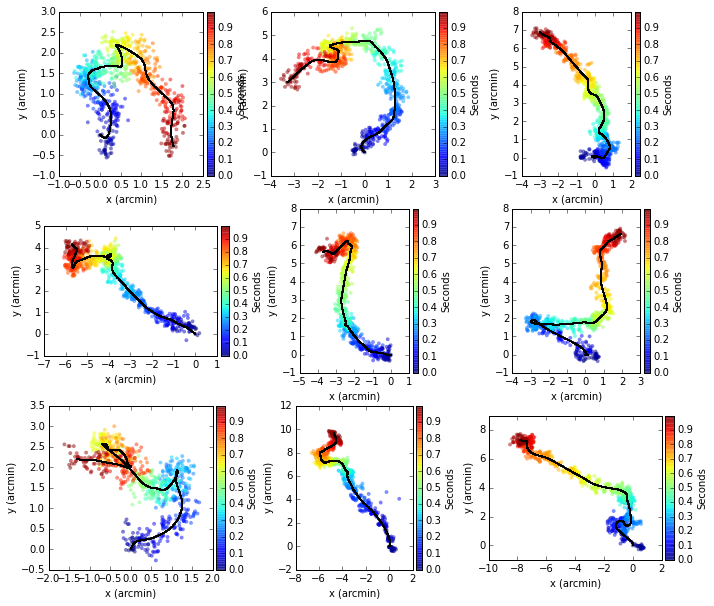

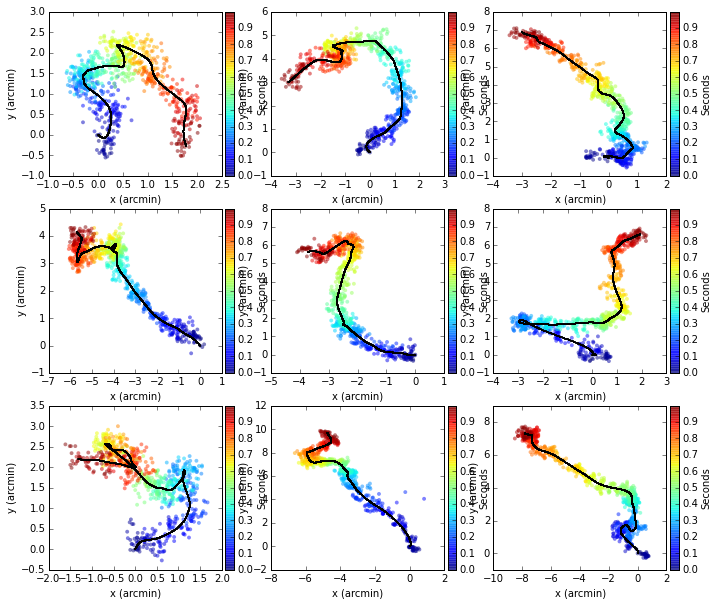

In [20]:
##load dependencies
import numpy as np
import os
from scipy.io import loadmat
from scipy import math
from scipy.signal import butter, lfilter, freqz
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from filterpy.stats import plot_covariance_ellipse
import xlrd
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import copy

#import eyetrace.py

wsize = 7 ##for sliding window in interpolation
##KF parameters - Velocity Model
ivx = 1e2
ivy = 1e2
tvx = 1e2 
tvy = 1e2
ov = (0.1)**2 
##parameters for Brownian Motion model
tx = 1e-1
ty = 1e-1

##look at and generate 9 trials
ntrials = 9

##save files here
output_dir = os.getcwd()

##data processing

##load in data and process with velocity model smoothing
trials = find_and_load('data')
trials = check_len(trials, 840)
trials = [interp_mf(trial) for trial in trials]
trials = filter_cvips(trials, wsize)
trials = kfiltervelocity(trials, ivx, ivy, tvx, tvy, ov)

#save files
mysavemat(trials, trials[0].kfdt,
        trials[0].filterinfo,
        os.path.join(output_dir, 'filtered_traces.mat'))

print '\nsmoothed veloicity model real data:'
eyetraceplot(trials, ntrials, True)
eyetraceplot(trials, ntrials, False)


velocity model generated data:


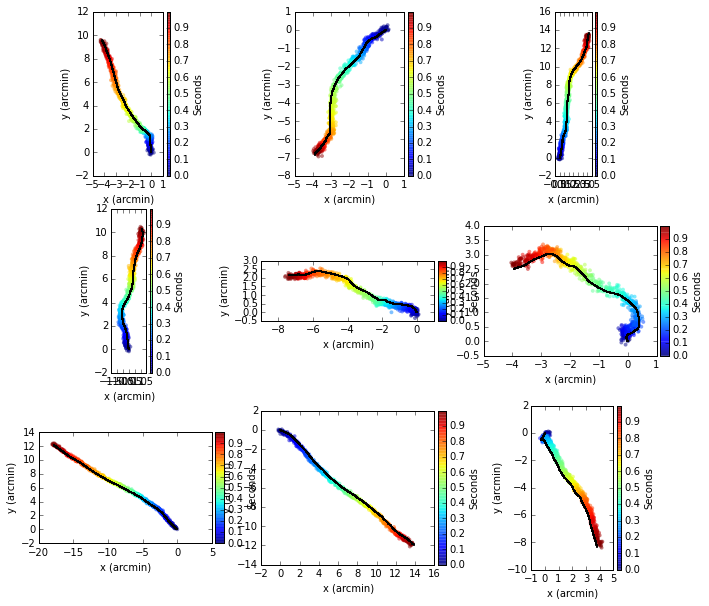

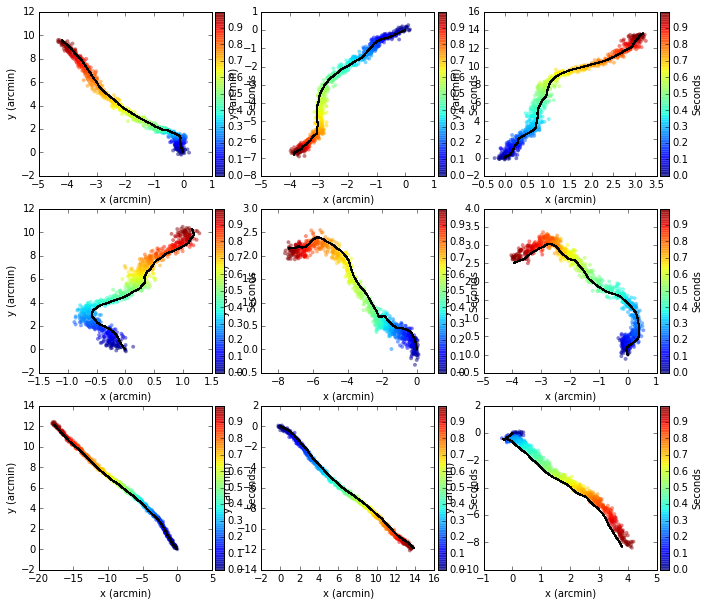

In [18]:
##generate traces using velocity model
dt = 1./len(trials[0].time)
adj = trials[0].kfadj
vmgentrials = gentracevelocity(ivx, ivy, tvx*dt, tvy*dt, ov, dt, adj, ntrials)
mysavemat(vmgentrials, dt,
        "eyetraces generated with the veloicty model",
        os.path.join(output_dir, 'vm_gen_traces.mat'))

print '\nvelocity model generated data:'
eyetraceplot(vmgentrials,ntrials, True)
eyetraceplot(vmgentrials,ntrials, False)


Brownian Motion model generated data:


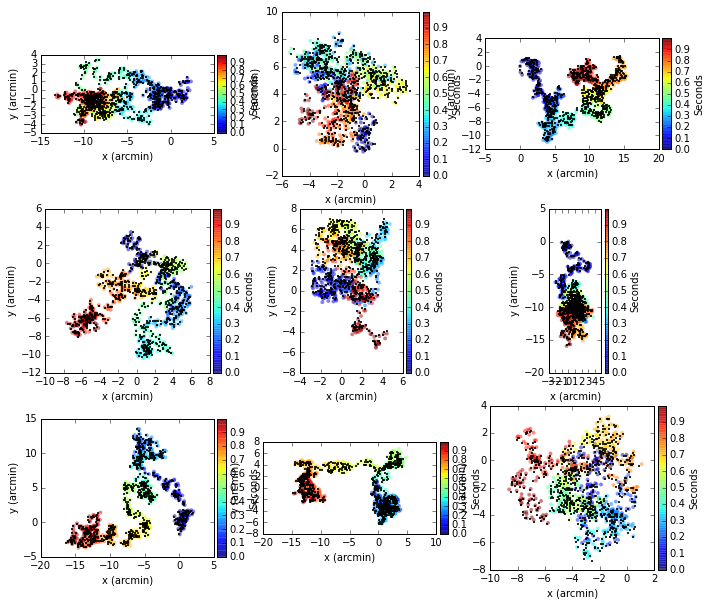

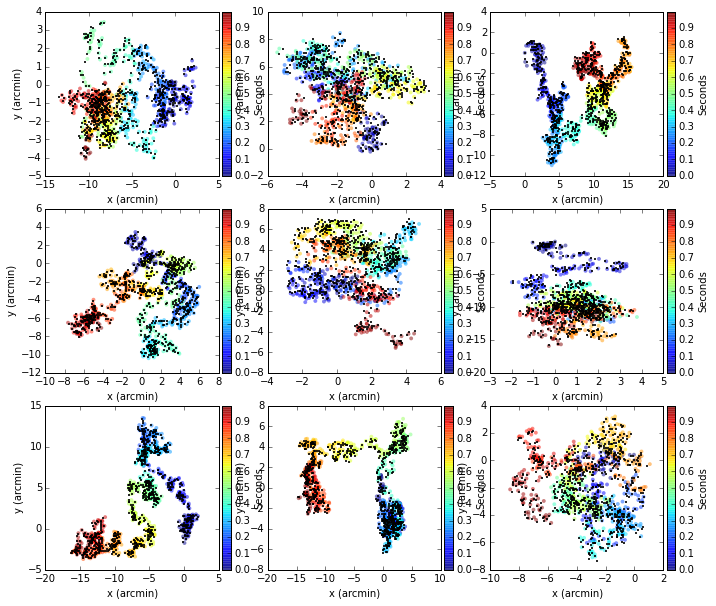

In [19]:
##generate traces using Brownian Motion model
bmgentrials = gentracebm(tx, ty, ov, dt, ntrials)

mysavemat(bmgentrials, dt,
        "eyetraces generated with the brownian motion model",
        os.path.join(output_dir, 'bm_gen_traces.mat'))

print '\nBrownian Motion model generated data:'
eyetraceplot(bmgentrials,ntrials,True)
eyetraceplot(bmgentrials,ntrials,False)